In [1]:
# #To be used on cloud platforms

# ! python -c "import pykeen" || pip install pykeen
# ! python -c "import scprep" || pip install scprep

In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD, pygsp
import rpy2, rpy2.situation, anndata2ri
from localization import * #Wavelet module

In [3]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab


# Prep

## Load scRNAseq data

We will have to use rpy to import the seurat object with the data. From there we already have code (from RNA Velo NBs) to extract metadata. Need to extract count matrices.

In [4]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/c

In [5]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython


In [6]:
%%R -i data_dir
library(tidyverse)
library(Seurat)

paste0(data_dir)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



[1] "/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab/data"


In [7]:
%%R -o dRnaSeq,dPHATEcoord

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Convert seurat object to anndata
dRnaSeq = as.SingleCellExperiment(d_fibWT)
#Export PHATE coordinates
dPHATEcoord = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))

rm(d_fibWT)

An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


Export list of genes detected in scRNA-seq dataset.
This will be used to subset the Knowledge Graph

In [8]:
print(f"Before filtering we have {len(dRnaSeq.var_names)} genes")
scanpy.pp.filter_genes(dRnaSeq, min_cells=4, inplace=True)
print(f"After filtering genes expressed in fewer than 4 cells we have {len(dRnaSeq.var_names)}")

dGenesSeq = list(dRnaSeq.var_names)

Before filtering we have 20867 genes
After filtering genes expressed in fewer than 4 cells we have 20666


In [9]:
print(dRnaSeq.obsm)#No DimRed were ported over
dRnaSeq

AxisArrays with keys: 


AnnData object with n_obs × n_vars = 3698 × 20666
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    var: 'n_cells'
    layers: 'logcounts'

In [10]:
#Add phate dims and view
dRnaSeq.obsm["X_PHATE"] = dPHATEcoord
del dPHATEcoord

<AxesSubplot: title={'center': 'Clusters'}, xlabel='PHATE_1', ylabel='PHATE_2'>

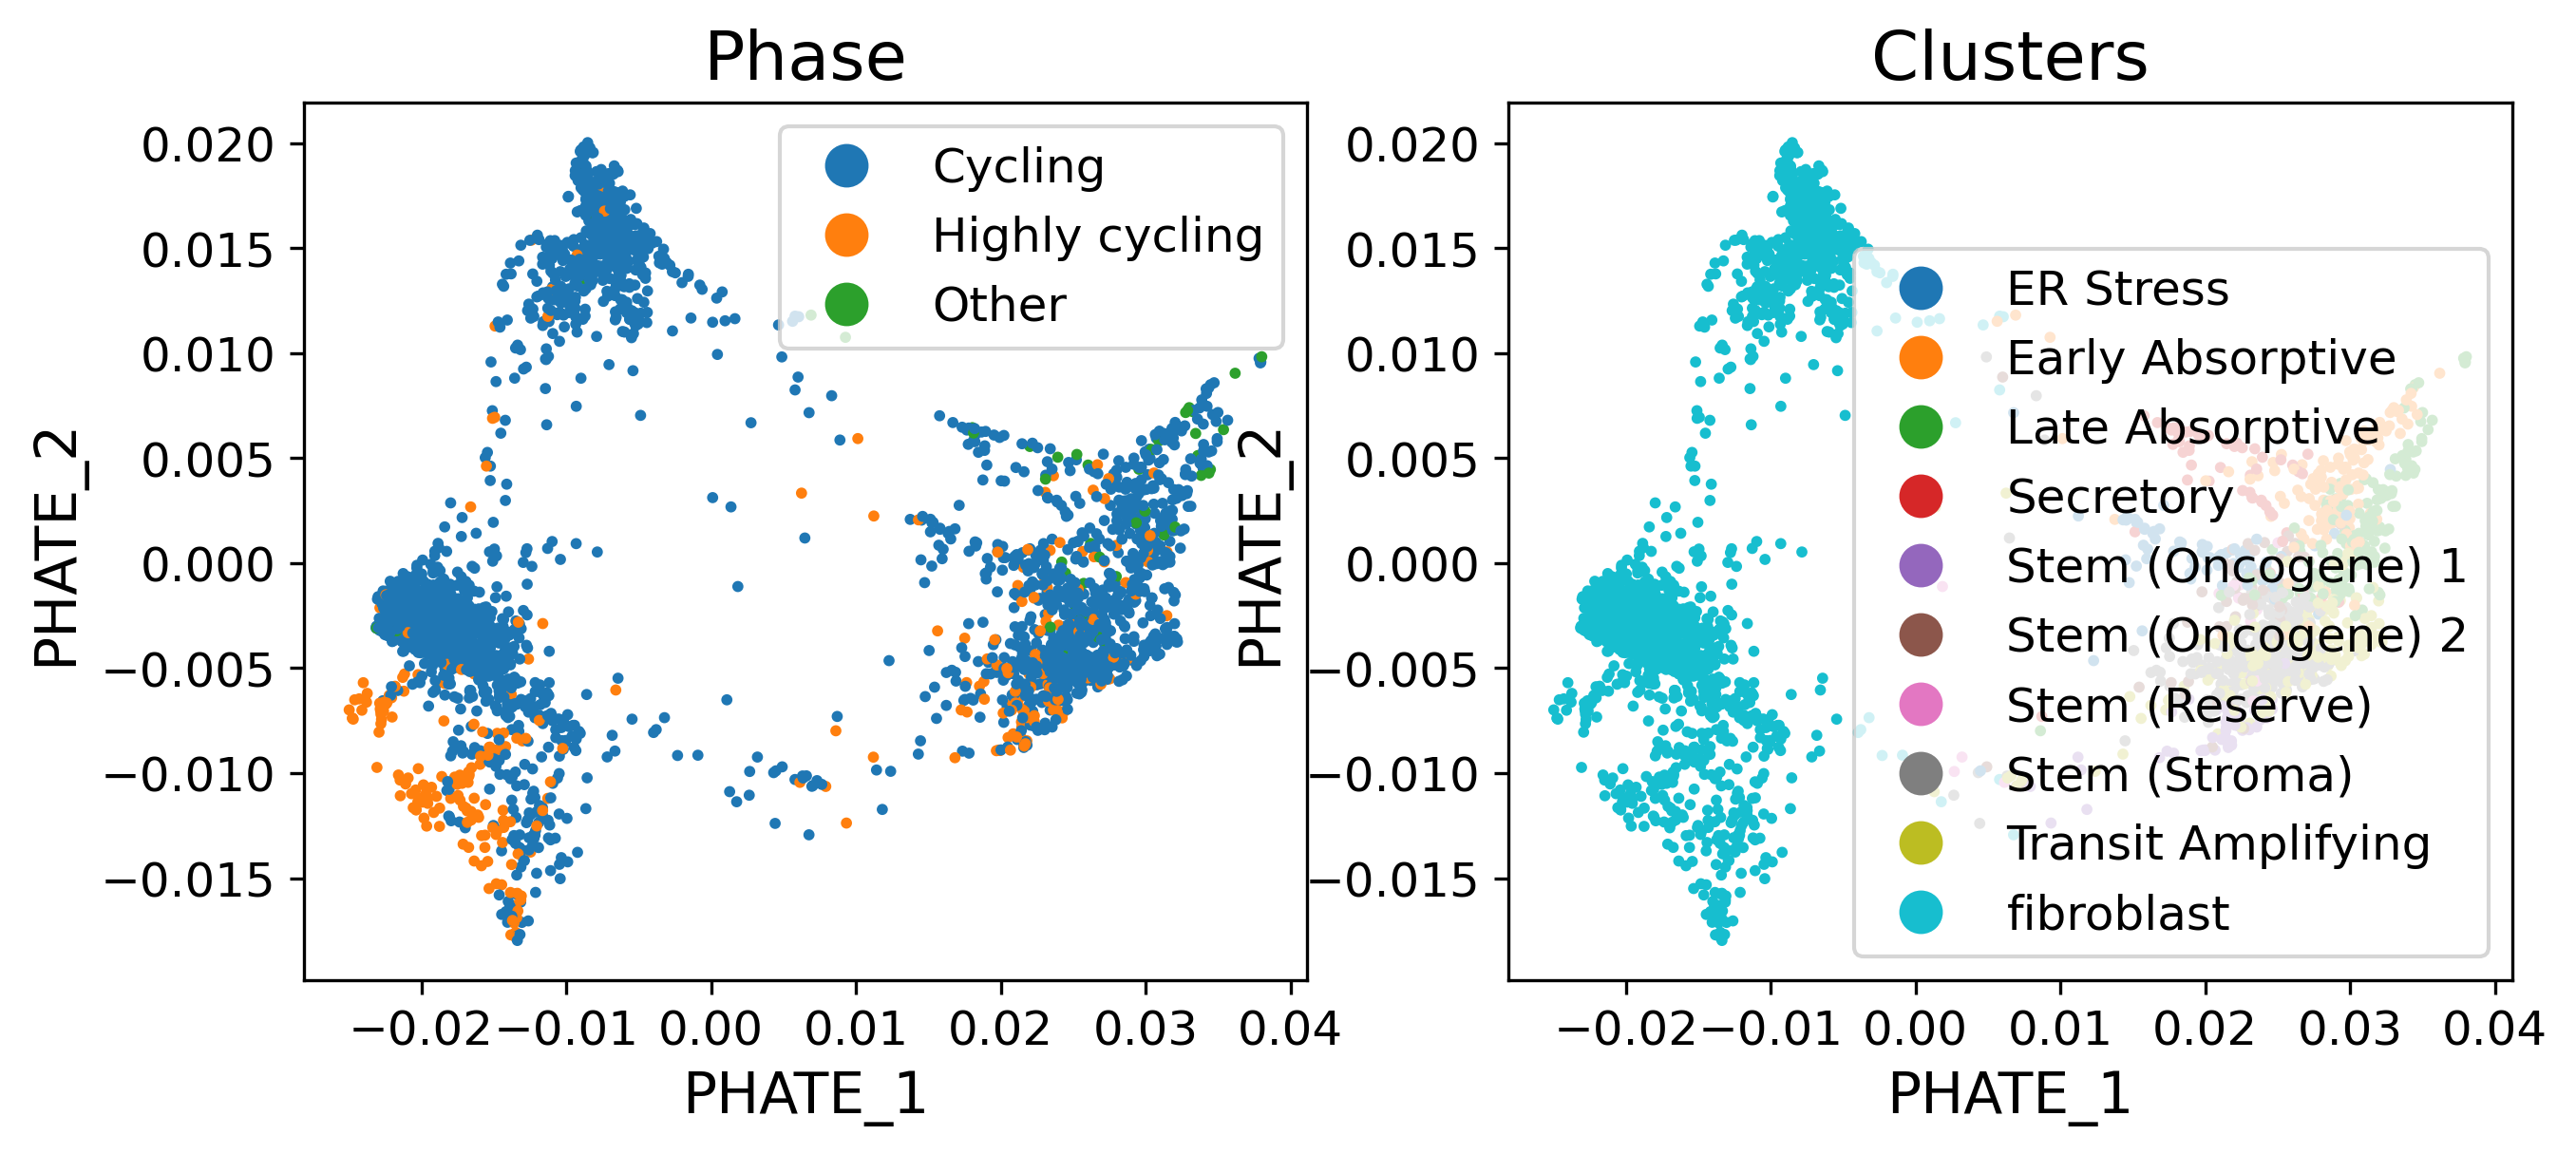

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.Phase, figsize=(4.8,3),
                     title=f"Phase", ax=ax[0])
scprep.plot.scatter2d(dRnaSeq.obsm["X_PHATE"], c=dRnaSeq.obs.finalPOPS, figsize=(4.8,3),
                     title=f"Clusters", ax=ax[1])

View data from AnnData object layers as dataframes.

In [12]:
print(dRnaSeq.to_df().head()) #Untransformed data
dRnaSeq.to_df(layer="logcounts").head() #Log transformed data to be used

                        Gm37363  Gm6123  Mrpl15  Gm37144  Lypla1  Gm37988  \
WT__AAACCCACAGCTTCCT-1      0.0     0.0     0.0      0.0     0.0      0.0   
WT__AAACCCAGTTCGAGCC-1      0.0     0.0     0.0      0.0     0.0      0.0   
WT__AAACGAAAGAAGGATG-1      0.0     0.0     0.0      0.0     0.0      0.0   
WT__AAACGAAAGGAAAGGT-1      0.0     0.0     0.0      0.0     0.0      0.0   
WT__AAACGAAAGTTAACGA-1      0.0     0.0     7.0      0.0     0.0      0.0   

                        Tcea1  Rgs20  Atp6v1h  Rb1cc1  ...  mt-Tg  mt-Nd3  \
WT__AAACCCACAGCTTCCT-1    2.0    0.0      0.0     0.0  ...    0.0     1.0   
WT__AAACCCAGTTCGAGCC-1    2.0    0.0      1.0     0.0  ...    0.0     1.0   
WT__AAACGAAAGAAGGATG-1    0.0    0.0      1.0     1.0  ...    0.0     3.0   
WT__AAACGAAAGGAAAGGT-1    0.0    0.0      0.0     0.0  ...    0.0     0.0   
WT__AAACGAAAGTTAACGA-1    2.0    0.0      2.0     1.0  ...    0.0     0.0   

                        mt-Nd4l  mt-Nd4  mt-Nd5  mt-Nd6  mt-Cytb  mt-Tt  \

,Gm37363,Gm6123,Mrpl15,Gm37144,Lypla1,Gm37988,Tcea1,Rgs20,Atp6v1h,Rb1cc1,...,mt-Tg,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,mt-Tt,partDsRedE,pEGFP
WT__AAACCCACAGCTTCCT-1,0.0,0.0,0.00000,0.0,0.0,0.0,1.050319,0.0,0.000000,0.000000,...,0.0,0.657148,0.000000,2.571135,0.000000,0.000000,3.988411,0.0,0.657148,0.0
WT__AAACCCAGTTCGAGCC-1,0.0,0.0,0.00000,0.0,0.0,0.0,0.829238,0.0,0.498218,0.000000,...,0.0,0.498218,0.000000,2.948746,1.077511,0.000000,4.079582,0.0,0.000000,0.0
WT__AAACGAAAGAAGGATG-1,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.469502,0.469502,...,0.0,1.028759,0.469502,2.563713,1.028759,0.000000,4.148146,0.0,0.000000,0.0
WT__AAACGAAAGGAAAGGT-1,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,2.811561,1.826475,0.000000,3.474191,0.0,0.000000,0.0
WT__AAACGAAAGTTAACGA-1,0.0,0.0,1.00638,0.0,0.0,0.0,0.402734,0.0,0.402734,0.221506,...,0.0,0.000000,0.000000,1.698031,0.911369,0.221506,2.780384,0.0,0.000000,0.0


## KG DataBase

The integrated database is the object ingested by pykeen's *TriplesFactory*.

Then, once the scRNAseq has been loaded in, we can also subset the genes in 
this dataframe to those present in the scRNA-seq count matrix.

In [13]:
dEdgeList = pd.read_csv(f"{data_dir}/dINT_simpl.tsv", sep="\t", header=None)[[0,2]]
print(dEdgeList.shape)

#Filter rows if either column not in sequencing data
dEdgeList = dEdgeList.loc[dEdgeList[0].isin(list(dGenesSeq)) & dEdgeList[2].isin(list(dGenesSeq))]
print(dEdgeList.shape)


(439023, 2)
(347024, 2)


View networkX graph object and show key graph metrics [info(), ...]

In [14]:
G = networkx.from_pandas_edgelist(dEdgeList, 0, 2)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
      networkx.number_of_isolates(G))
print("The graph is connected:",
     networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

/tmp/ipykernel_12069/2064377355.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


Graph with 12185 nodes and 173152 edges, with a density of 0.0023326097364686623
We have this many isolates:  0
The graph is connected: False

We have 99 connected subgraphs
Component 1: Graph with 11974 nodes and 173038 edges, with a density of 0.00241395542397877
Component 2: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 3: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 4: Graph with 3 nodes and 2 edges, with a density of 0.6666666666666666
Component 5: Graph with 3 nodes and 2 edges, with a density of 0.6666666666666666
Component 6: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 7: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 8: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 9: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 10: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 11: Graph with 3 nodes and 3 edges, with a density of 1.0
Component 12: Graph with 2 nodes

/tmp/ipykernel_12069/2064377355.py:14: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")


In [15]:
# networkx.draw(Gcomponents[0])

## Process scRNA data

### Normalise and denoise gene expression data

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Then subset to genes present in KG.
Then normalise so that the gene expression distributions are equally big for each cell.

We will compute MAGIC with default knn-related params (and not giving it a precomputed graph) and using all genes. However, with the `genes` argument, one should be able to return a processed matrix with only the genes present in the KG (whil still leveraging allthe full suite of genes in the dataset)

In [16]:
#MAGIC
magic_op = magic.MAGIC(
    knn=5, # knn_max set to 3*knn by default
    knn_dist="euclidean",
    decay=1, t=3, n_pca=100, random_state=12,
    n_jobs=-2 #All but one
                      )

In [17]:
help(magic.MAGIC())

Help on MAGIC in module magic.magic object:

class MAGIC(sklearn.base.BaseEstimator)
 |  MAGIC(knn=5, knn_max=None, decay=1, t=3, n_pca=100, solver='exact', knn_dist='euclidean', n_jobs=1, random_state=None, verbose=1)
 |  
 |  MAGIC operator which performs dimensionality reduction.
 |  
 |  Markov Affinity-based Graph Imputation of Cells (MAGIC) is an
 |  algorithm for denoising and transcript recover of single cells
 |  applied to single-cell RNA sequencing data, as described in
 |  van Dijk et al, 2018 [1]_.
 |  
 |  Parameters
 |  ----------
 |  
 |  knn : int, optional, default: 5
 |      number of nearest neighbors from which to compute kernel bandwidth
 |  
 |  knn_max : int, optional, default: None
 |      maximum number of nearest neighbors with nonzero connection.
 |      If `None`, will be set to 3 * `knn`
 |  
 |  decay : int, optional, default: 1
 |      sets decay rate of kernel tails.
 |      If None, alpha decaying kernel is not used
 |  
 |  t : int, optional, default:

In [18]:
# #Original approach was to get all nodes in Knowledge Graph
# gKG = dEdgeList.melt()["value"].drop_duplicates()

#Use instead nodes in 1st connected KG component

In [19]:
dMagicRnaSeq = magic_op.fit_transform(
    X = dRnaSeq.to_df(layer="logcounts"),
    genes = list(Gcomponents[0].nodes())
)
dMagicRnaSeq

Calculating MAGIC...
  Running MAGIC on 3698 cells and 20666 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.67 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.95 seconds.
    Calculating affinities...
    Calculated affinities in 0.93 seconds.
  Calculated graph and diffusion operator in 5.76 seconds.
  Running MAGIC with `solver='exact'` on 11974-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 2.23 seconds.
Calculated MAGIC in 36.05 seconds.


,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Alkal1,Rrs1,Adhfe1,Mybl1,...,mt-Co2,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb
WT__AAACCCACAGCTTCCT-1,0.656304,0.127007,0.563843,0.000181,0.280981,0.297285,0.074316,0.389065,0.311475,0.017975,...,0.040084,0.331490,0.222017,0.170981,0.432338,0.042554,2.561051,0.880707,0.083880,3.903027
WT__AAACCCAGTTCGAGCC-1,0.675545,0.143338,0.621588,0.000004,0.330035,0.303905,0.048736,0.452450,0.235822,0.019018,...,0.042244,0.371615,0.227089,0.139292,0.449823,0.045446,2.519368,0.852084,0.078670,3.914081
WT__AAACGAAAGAAGGATG-1,0.592671,0.118198,0.463124,0.000037,0.248782,0.276751,0.078989,0.357645,0.293478,0.013379,...,0.036207,0.318393,0.233966,0.168486,0.399835,0.068342,2.506547,0.912862,0.056960,3.858059
WT__AAACGAAAGGAAAGGT-1,0.372222,0.450522,0.207975,0.002774,0.176997,0.179788,0.000000,0.029640,0.000000,0.000289,...,0.062115,0.221544,0.163493,0.210329,0.120284,0.009243,1.835800,0.843868,0.031790,2.537121
WT__AAACGAAAGTTAACGA-1,0.653948,0.318248,0.318942,0.010842,0.145051,0.141733,0.001585,0.106739,0.001012,0.001208,...,0.046502,0.217982,0.168517,0.128289,0.052599,0.036702,1.888962,0.703151,0.053150,3.189778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.484435,0.207534,0.521920,0.018330,0.387812,0.133705,0.000013,0.080484,0.000161,0.004286,...,0.063694,0.146701,0.083146,0.077182,0.093548,0.006015,1.220427,0.757025,0.083483,2.117315
WT__TTTGGTTTCCGTAGTA-1,0.574821,0.161695,0.522487,0.000098,0.246060,0.324676,0.070716,0.390849,0.393466,0.005660,...,0.050907,0.420383,0.272600,0.206183,0.447592,0.069178,2.618978,1.159801,0.069928,3.866193
WT__TTTGTTGTCGCTTGAA-1,0.403604,0.391307,0.321920,0.003810,0.185610,0.204567,0.000129,0.051978,0.000239,0.001790,...,0.054612,0.276085,0.188807,0.190672,0.076078,0.023596,1.949451,0.808810,0.059591,3.012844
WT__TTTGTTGTCTGAATCG-1,0.772077,0.153105,0.622268,0.009051,0.404417,0.286483,0.088398,0.350856,0.033717,0.010868,...,0.050711,0.323333,0.197531,0.155903,0.347546,0.037113,2.426871,0.708864,0.087412,3.921434


View gene-gene scatter for cycle, fibro and epi genes b4 and after MAGIC

In [20]:
print("Cd44" in dMagicRnaSeq.columns)
print("Fabp2" in dMagicRnaSeq.columns)
print("Epcam" in dMagicRnaSeq.columns)

True
True
True


In [21]:
print("Pdgfra" in dMagicRnaSeq.columns)
print("Cd34" in dMagicRnaSeq.columns)
print("Thy1" in dMagicRnaSeq.columns)

True
True
True


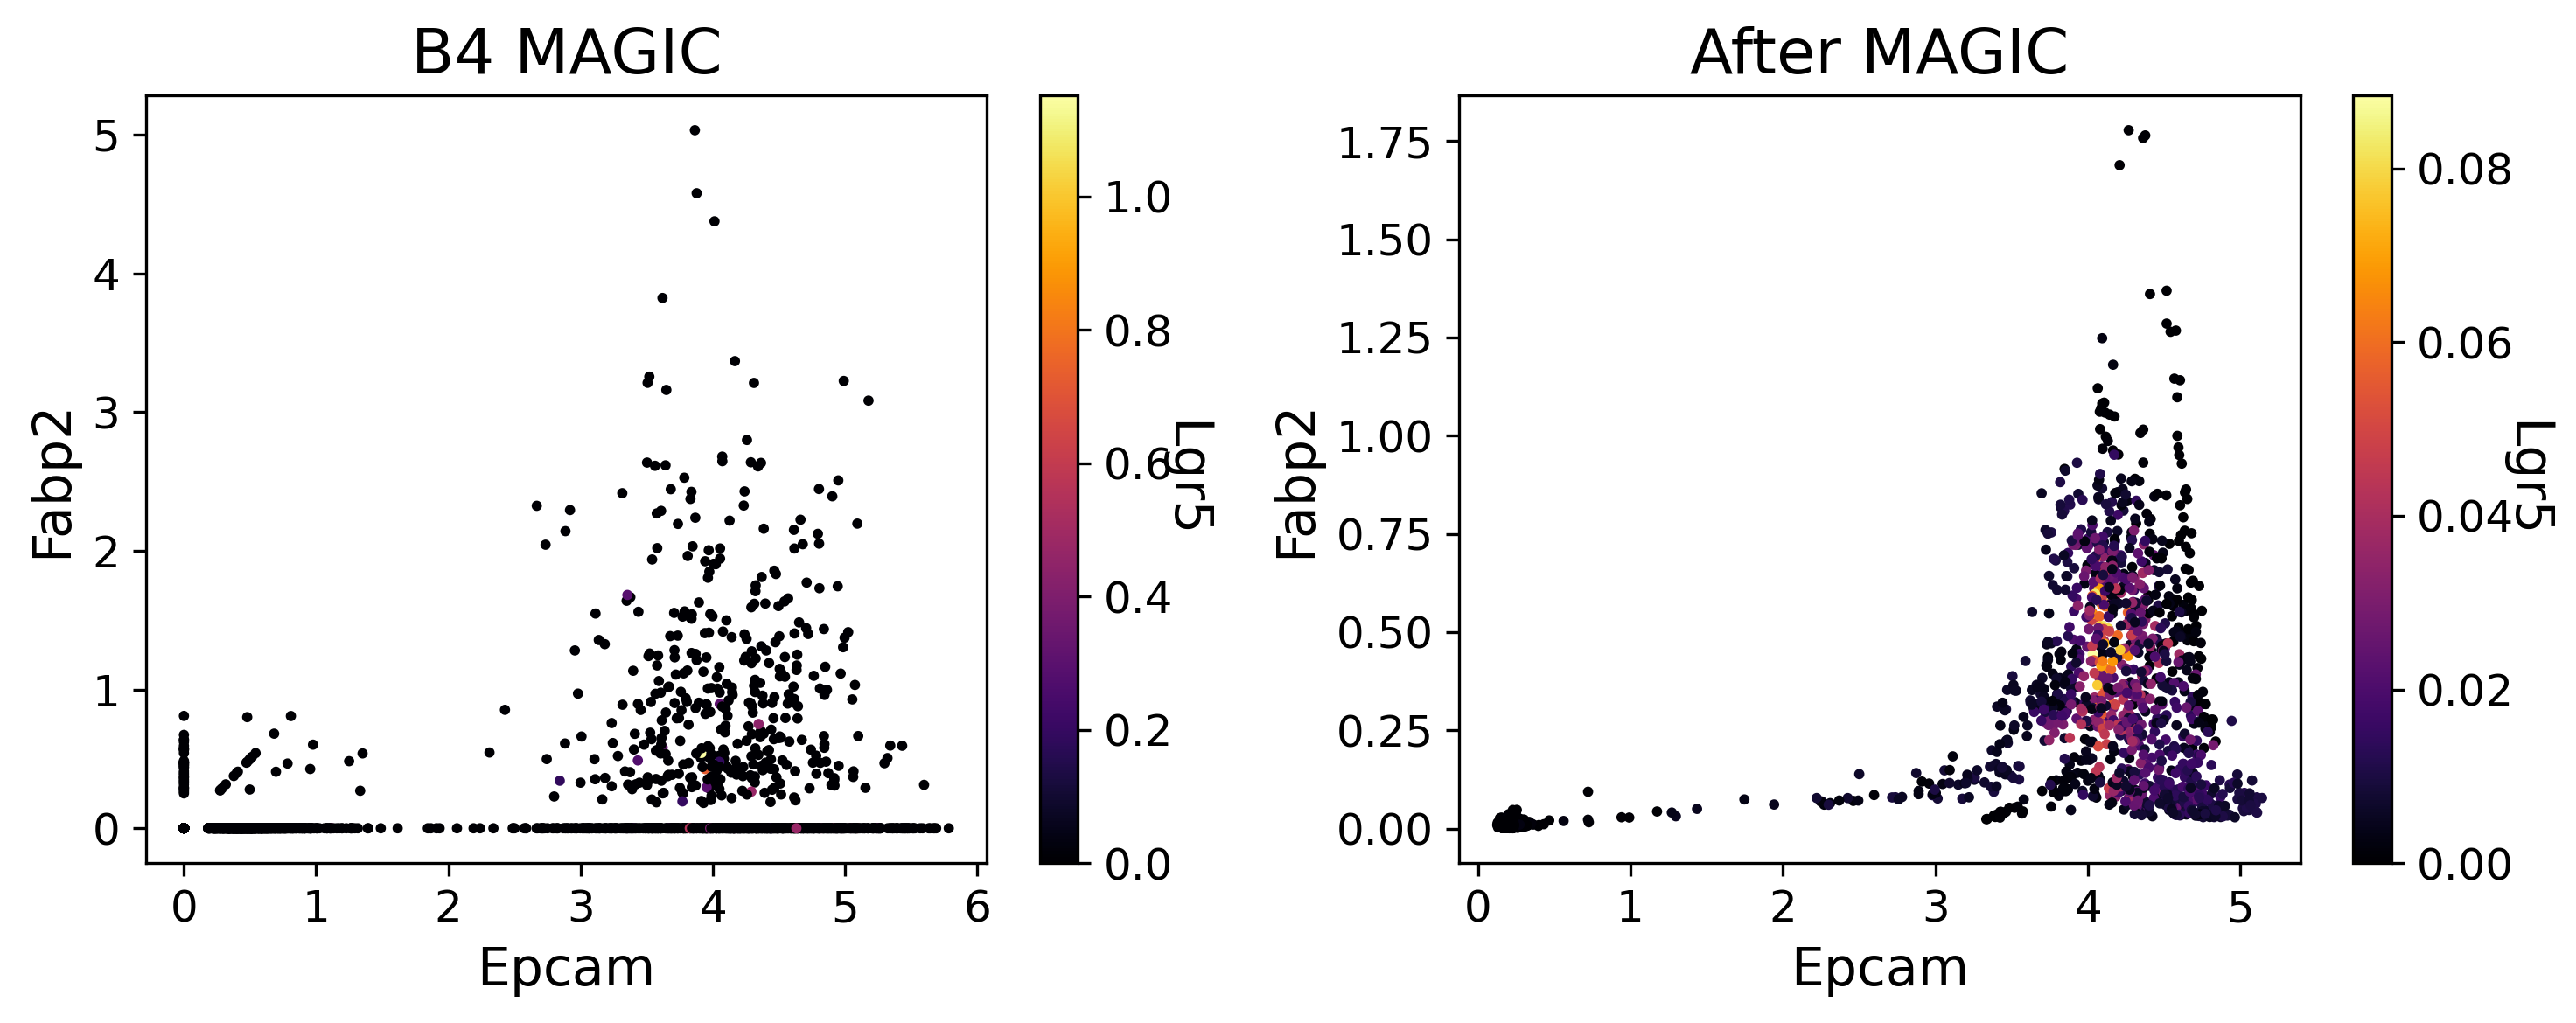

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq.to_df(layer="logcounts")["Epcam"], y=dRnaSeq.to_df(layer="logcounts")["Fabp2"], c=dRnaSeq.to_df(layer="logcounts")["Lgr5"],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq["Epcam"], y=dMagicRnaSeq["Fabp2"], c=dMagicRnaSeq["Lgr5"],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

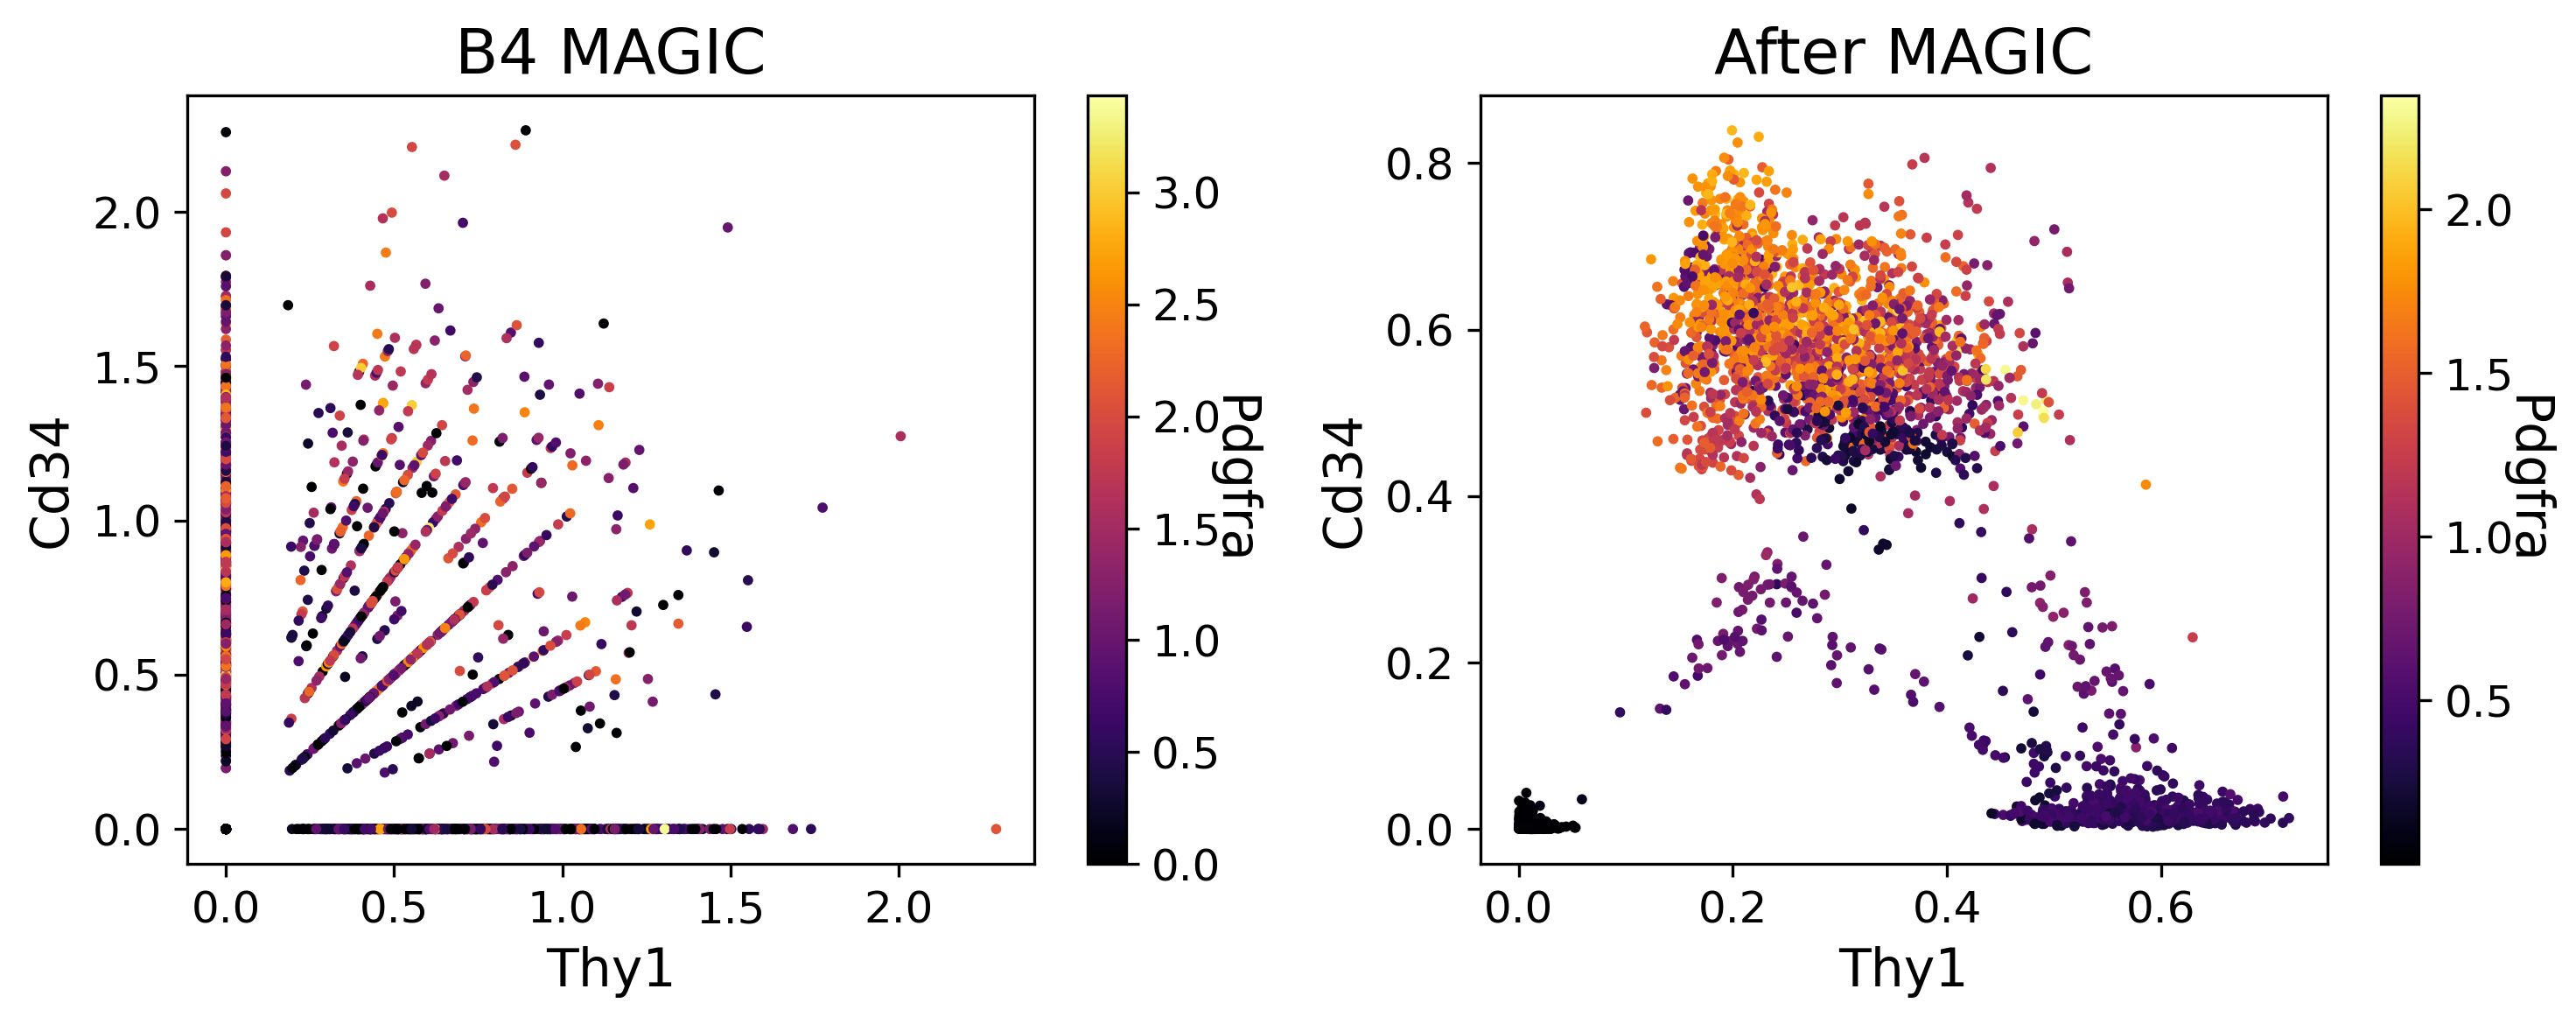

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq.to_df(layer="logcounts")["Thy1"], y=dRnaSeq.to_df(layer="logcounts")["Cd34"], c=dRnaSeq.to_df(layer="logcounts")["Pdgfra"],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq["Thy1"], y=dMagicRnaSeq["Cd34"], c=dMagicRnaSeq["Pdgfra"],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

Now, let's create a dataframe where gene expression values have been scalled row-wise (might be useful for the first DEMD approach, for wich we would need the gene expression arrays to summ up to the same value across all cells).

We can apply this scalling by computing the total sum of values for each row and then dividing the expression values for each gene in that cell by that sum.

In [24]:
help(pd.DataFrame.sum)

Help on function sum in module pandas.core.generic:

sum(self, axis=None, skipna=None, level=None, numeric_only=None, min_count=0, **kwargs)
    Return the sum of the values over the requested axis.
    
    This is equivalent to the method ``numpy.sum``.
    
    Parameters
    ----------
    axis : {index (0), columns (1)}
        Axis for the function to be applied on.
    skipna : bool, default True
        Exclude NA/null values when computing the result.
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a Series.
    numeric_only : bool, default None
        Include only float, int, boolean columns. If None, will attempt to use
        everything, then use only numeric data. Not implemented for Series.
    min_count : int, default 0
        The required number of valid values to perform the operation. If fewer than
        ``min_count`` non-NA values are present the result will b

In [25]:
%%time
#Cell-scalled GEX:
dScalRnaSeq = dMagicRnaSeq.div(dMagicRnaSeq.sum(axis=1), axis=0)
dScalRnaSeq

CPU times: user 214 ms, sys: 72.2 ms, total: 286 ms
Wall time: 286 ms


,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Alkal1,Rrs1,Adhfe1,Mybl1,...,mt-Co2,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb
WT__AAACCCACAGCTTCCT-1,0.000226,0.000044,0.000194,6.221552e-08,0.000097,0.000102,2.554800e-05,0.000134,1.070781e-04,6.179490e-06,...,0.000014,0.000114,0.000076,0.000059,0.000149,0.000015,0.000880,0.000303,0.000029,0.001342
WT__AAACCCAGTTCGAGCC-1,0.000223,0.000047,0.000205,1.308804e-09,0.000109,0.000100,1.609372e-05,0.000149,7.787356e-05,6.280003e-06,...,0.000014,0.000123,0.000075,0.000046,0.000149,0.000015,0.000832,0.000281,0.000026,0.001293
WT__AAACGAAAGAAGGATG-1,0.000204,0.000041,0.000160,1.263857e-08,0.000086,0.000095,2.722690e-05,0.000123,1.011599e-04,4.611618e-06,...,0.000012,0.000110,0.000081,0.000058,0.000138,0.000024,0.000864,0.000315,0.000020,0.001330
WT__AAACGAAAGGAAAGGT-1,0.000151,0.000183,0.000084,1.126299e-06,0.000072,0.000073,0.000000e+00,0.000012,0.000000e+00,1.174401e-07,...,0.000025,0.000090,0.000066,0.000085,0.000049,0.000004,0.000745,0.000343,0.000013,0.001030
WT__AAACGAAAGTTAACGA-1,0.000241,0.000117,0.000117,3.987783e-06,0.000053,0.000052,5.831393e-07,0.000039,3.721350e-07,4.442683e-07,...,0.000017,0.000080,0.000062,0.000047,0.000019,0.000013,0.000695,0.000259,0.000020,0.001173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.000194,0.000083,0.000209,7.327419e-06,0.000155,0.000053,5.100217e-09,0.000032,6.450340e-08,1.713255e-06,...,0.000025,0.000059,0.000033,0.000031,0.000037,0.000002,0.000488,0.000303,0.000033,0.000846
WT__TTTGGTTTCCGTAGTA-1,0.000197,0.000055,0.000179,3.356934e-08,0.000084,0.000111,2.422950e-05,0.000134,1.348140e-04,1.939159e-06,...,0.000017,0.000144,0.000093,0.000071,0.000153,0.000024,0.000897,0.000397,0.000024,0.001325
WT__TTTGTTGTCGCTTGAA-1,0.000153,0.000148,0.000122,1.445305e-06,0.000070,0.000078,4.893996e-08,0.000020,9.082120e-08,6.790621e-07,...,0.000021,0.000105,0.000072,0.000072,0.000029,0.000009,0.000739,0.000307,0.000023,0.001143
WT__TTTGTTGTCTGAATCG-1,0.000243,0.000048,0.000196,2.851631e-06,0.000127,0.000090,2.785151e-05,0.000111,1.062335e-05,3.424308e-06,...,0.000016,0.000102,0.000062,0.000049,0.000110,0.000012,0.000765,0.000223,0.000028,0.001236


# Approach 2-Wavelets:

From the gene-gene KG get a wavelet dictionary at multiscales based on gene expression.
The resulting gene**X**wavelet matrix can be multiplied against a gene**X**cell matrix (from scRNA-seq data) in order to project the cells onto the wavelets.

This approach should be able to incorporate proteomic data from CyTOF too, as PTMs will also be nodes on the graph and we will work with a node**X**wavelet matrix.

In [26]:
help(phate.PHATE())

Help on PHATE in module phate.phate object:

class PHATE(sklearn.base.BaseEstimator)
 |  PHATE(n_components=2, knn=5, decay=40, n_landmark=2000, t='auto', gamma=1, n_pca=100, mds_solver='sgd', knn_dist='euclidean', knn_max=None, mds_dist='euclidean', mds='metric', n_jobs=1, random_state=None, verbose=1, **kwargs)
 |  
 |  PHATE operator which performs dimensionality reduction.
 |  
 |  Potential of Heat-diffusion for Affinity-based Trajectory Embedding
 |  (PHATE) embeds high dimensional single-cell data into two or three
 |  dimensions for visualization of biological progressions as described
 |  in Moon et al, 2017 [1]_.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_components : int, optional, default: 2
 |      number of dimensions in which the data will be embedded
 |  
 |  knn : int, optional, default: 5
 |      number of nearest neighbors on which to build kernel
 |  
 |  decay : int, optional, default: 40
 |      sets decay rate of kernel tails.
 |      If None, alpha decaying k

## Compute wavelets

First convert the current networkx graph (for now the 1st component) into a pygsp Graph.
That object can then be used by the wavelet code.

1- Using [networkx](https://networkx.org/documentation/stable/install.html) package.

    - From the integrated database, we've made a pandas dataframe that has only the 
    source and target columns and then use that to make a NetworkX Graph object 
    with `from_pandas_edgelist`

In [28]:
#Using 1st graph component
Gcomponents[0]

In [29]:
print(pygsp.__version__)

pyG = pygsp.graphs.Graph(W=networkx.to_numpy_array(Gcomponents[0]))
pyG

0.5.1


2022-09-30 11:51:26,947:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [30]:
wavloc = Localizer(pyG) #Takes only pygsp graphs
wavloc.CalculateWavelets(J=4) #J is possibly the scale param. Double check with @Aarthi
wavloc.FlattenAndNormalize()
wavloc

Calculating Wavelets Using J = 4


100%|██████████| 2/2 [00:31<00:00, 15.98s/it]


Flattening and Normalizing Wavelets


100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Resulting object, accessed via .FlatWaves, is a gene**X**wavelet matrix, with the 11974 genes we had in the KG

In [37]:
wavloc.FlatWaves.shape

(11974, 47896)

## Project cells on geneXwavelet matrix

To project the cells on the gene**X**wavelet matrix we will multiply a cell**X**gene matrix by the gene**X**wavelet matrix, resulting in a cell**X**wavelet matrix

In [38]:
#Reorder GEX data based on adjacency matrix
dScalRnaSeq = dScalRnaSeq.reindex(
                columns=list(Gcomponents[0].nodes())
                )
dScalRnaSeq

,Tgfb1,Tgfbr1,Tgfbr2,Tgfb2,Tgfb3,Acvr1b,Acvr1,Bmp2,Bmpr1a,Acvr2a,...,Fam172a,Zbtb10,Myef2,Lyrm9,Ms4a6b,Efcab12,Cic,Mast4,Zfp511,Arhgap12
WT__AAACCCACAGCTTCCT-1,0.000141,0.000063,0.000169,1.374713e-04,5.452961e-06,0.000028,0.000043,1.167302e-08,0.000041,0.000016,...,0.000032,3.383457e-06,0.000133,0.000038,0.000000e+00,6.932591e-07,0.000066,0.000230,0.000084,0.000023
WT__AAACCCAGTTCGAGCC-1,0.000124,0.000043,0.000184,1.049721e-04,5.307356e-06,0.000026,0.000045,3.491096e-09,0.000035,0.000018,...,0.000049,2.807124e-06,0.000169,0.000041,0.000000e+00,5.024980e-07,0.000060,0.000199,0.000069,0.000025
WT__AAACGAAAGAAGGATG-1,0.000150,0.000068,0.000177,9.334674e-05,1.000530e-05,0.000034,0.000040,3.019178e-07,0.000034,0.000013,...,0.000035,1.106607e-05,0.000131,0.000035,4.354615e-09,5.231102e-08,0.000049,0.000213,0.000073,0.000024
WT__AAACGAAAGGAAAGGT-1,0.000039,0.000002,0.000123,0.000000e+00,0.000000e+00,0.000023,0.000012,1.551275e-04,0.000072,0.000029,...,0.000027,0.000000e+00,0.000022,0.000027,0.000000e+00,0.000000e+00,0.000033,0.000076,0.000082,0.000171
WT__AAACGAAAGTTAACGA-1,0.000067,0.000027,0.000126,8.286411e-07,4.817592e-09,0.000013,0.000034,2.885368e-05,0.000031,0.000015,...,0.000025,4.811460e-08,0.000056,0.000048,0.000000e+00,0.000000e+00,0.000024,0.000109,0.000100,0.000072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WT__TTTGGTTTCATTCTTG-1,0.000070,0.000012,0.000092,9.522622e-08,0.000000e+00,0.000031,0.000030,3.452667e-05,0.000050,0.000035,...,0.000015,4.018585e-09,0.000059,0.000033,0.000000e+00,0.000000e+00,0.000031,0.000083,0.000129,0.000127
WT__TTTGGTTTCCGTAGTA-1,0.000134,0.000068,0.000199,1.077079e-04,9.045638e-06,0.000038,0.000053,4.849816e-07,0.000039,0.000011,...,0.000040,6.468970e-06,0.000142,0.000027,0.000000e+00,1.012713e-07,0.000059,0.000226,0.000076,0.000034
WT__TTTGTTGTCGCTTGAA-1,0.000052,0.000014,0.000133,2.381083e-08,0.000000e+00,0.000018,0.000022,6.259511e-05,0.000058,0.000026,...,0.000020,1.591961e-07,0.000047,0.000024,0.000000e+00,0.000000e+00,0.000029,0.000090,0.000089,0.000130
WT__TTTGTTGTCTGAATCG-1,0.000154,0.000117,0.000109,1.879908e-05,1.943206e-05,0.000018,0.000045,6.792367e-06,0.000035,0.000015,...,0.000043,7.465031e-06,0.000112,0.000037,1.288435e-07,0.000000e+00,0.000038,0.000238,0.000138,0.000031


In [40]:
#Multiply 2 matrices using the dot product
cell_projection = np.dot(dScalRnaSeq, wavloc.FlatWaves)
cell_projection.shape #Shape should be 3.7k rows by 47.9k columns

(3698, 47896)

This is essentially a cell-cell graph based on their differences on the comns KG. 
We can thus use this to get some phate embeddings or any other downstream steps.

In [41]:
#Save to file as compressed npy object
np.savez_compressed(f"{data_dir}/cell_projection.npz", cell_projection)

In [47]:
cell_projection = np.load(f"{data_dir}/cell_projection.npz")["arr_0"]#Dict-like struct.Default arr_N keys
cell_projection.shape 

(3698, 47896)

## Downstream 

### Embed projections on PHATE

In [48]:
phate_op = phate.PHATE() 
data_phate = phate_op.fit_transform(cell_projection) 

Calculating PHATE...
  Running PHATE on 3698 observations and 47896 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 11.14 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.51 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 11.69 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.03 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.38 seconds.
  Calculated landmark operator in 6.54 seconds.
  Calculating optimal t...
    Automatically selected t = 49
  Calculated optimal t in 1.13 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.80 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.75 seconds.
Calculated PHATE in 24.92 seconds.


In [52]:
print(data_phate.shape)
dCellEmbeddings = pd.DataFrame(data=data_phate, index = dScalRnaSeq.index, columns=["PHATE1","PHATE2"])
dCellEmbeddings

(3698, 2)


,PHATE1,PHATE2
WT__AAACCCACAGCTTCCT-1,-0.015379,-0.008503
WT__AAACCCAGTTCGAGCC-1,-0.017130,-0.006020
WT__AAACGAAAGAAGGATG-1,-0.015640,-0.008031
WT__AAACGAAAGGAAAGGT-1,0.029643,0.006417
WT__AAACGAAAGTTAACGA-1,0.033736,-0.000993
...,...,...
WT__TTTGGTTTCATTCTTG-1,0.031820,0.003316
WT__TTTGGTTTCCGTAGTA-1,-0.015181,-0.008476
WT__TTTGTTGTCGCTTGAA-1,0.031656,0.002735
WT__TTTGTTGTCTGAATCG-1,-0.008557,0.014882


<AxesSubplot: title={'center': 'Cells on communication KG (col=clust)'}, xlabel='PHATE1', ylabel='PHATE2'>

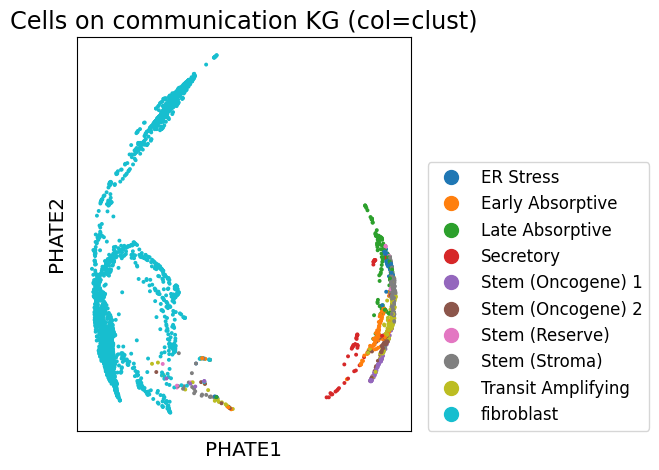

In [53]:
scprep.plot.scatter2d(
    dCellEmbeddings, c=dRnaSeq.obs.finalPOPS,
    title="Cells on communication KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))

#### Results

Using the wavelet approach we get a very similar PHATE space as that from the DEMD approach. 

Before continuing further we should explore some kind of tunning of the KG, perhaps aiminig to *sparsify* it?